In [1]:
!pip install google-cloud-firestore
!pip install protobuf==3.20.*
!pip install firebase-admin



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# Library Import

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from firebase_admin import credentials, initialize_app, db
import firebase_admin
import datetime

2024-11-23 05:33:53.038674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 05:33:53.245886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-23 05:33:53.245909: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-11-23 05:33:53.319127: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 05:33:54.644907: W tensorflow/stream_executor/platform/de

# Data Cleaning

In [3]:
# The error message indicates an issue with decoding the CSV file using 'utf-8' encoding.
# Let's try reading the file using a different encoding, such as 'latin1', which is often used as a workaround for such issues.

import pandas as pd

file_path = "/work/mtcars.csv"
df = pd.read_csv(file_path, encoding='latin1')
print(df.head())
print(df)
print(df.describe())
print(df.info())
print(df.isnull().sum())

               model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2  
                  model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  \
0             Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1   
1         Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1   
2            Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1   
3        Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0   
4     Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17

In [6]:
df.dropna(inplace=True)
print("Missing values:\n", df.isnull().sum())
print("Duplicated rows:\n", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Missing values:
 model    0
mpg      0
cyl      0
disp     0
hp       0
drat     0
wt       0
qsec     0
vs       0
am       0
gear     0
carb     0
dtype: int64
Duplicated rows:
 0


# Exploratory Data Analysis (EDA)

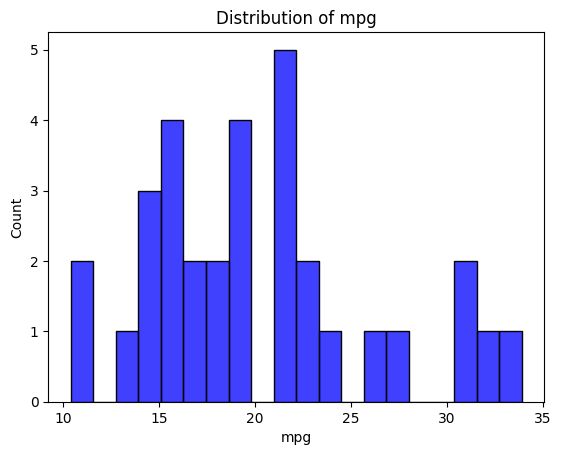

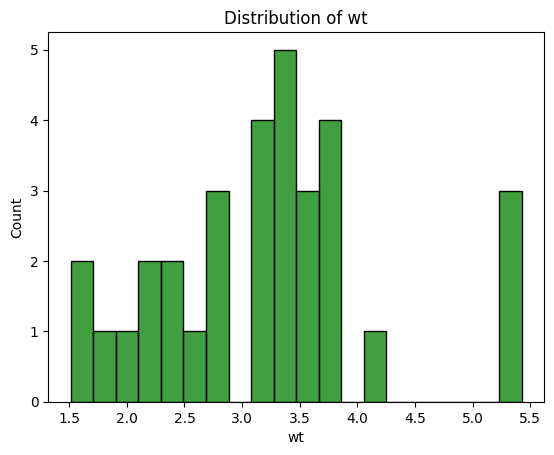

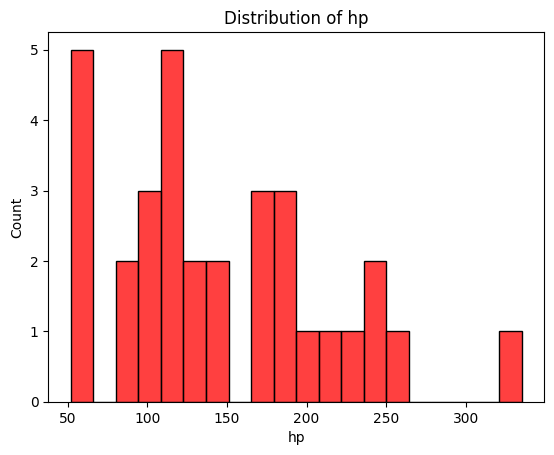

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing kolom agar dapat digunakan
df['mpg'] = df['mpg'].astype(float)
df['wt'] = df['wt'].astype(float)
df['hp'] = df['hp'].astype(int)

# Plot distribusi
# Distribusi mpg
sns.histplot(df['mpg'], bins=20, color='blue')
plt.title('Distribution of mpg')
plt.xlabel('mpg')
plt.show()

# Distribusi wt
sns.histplot(df['wt'], bins=20, color='green')
plt.title('Distribution of wt')
plt.xlabel('wt')
plt.show()

# Distribusi hp
sns.histplot(df['hp'], bins=20, color='red')
plt.title('Distribution of hp')
plt.xlabel('hp')
plt.show()

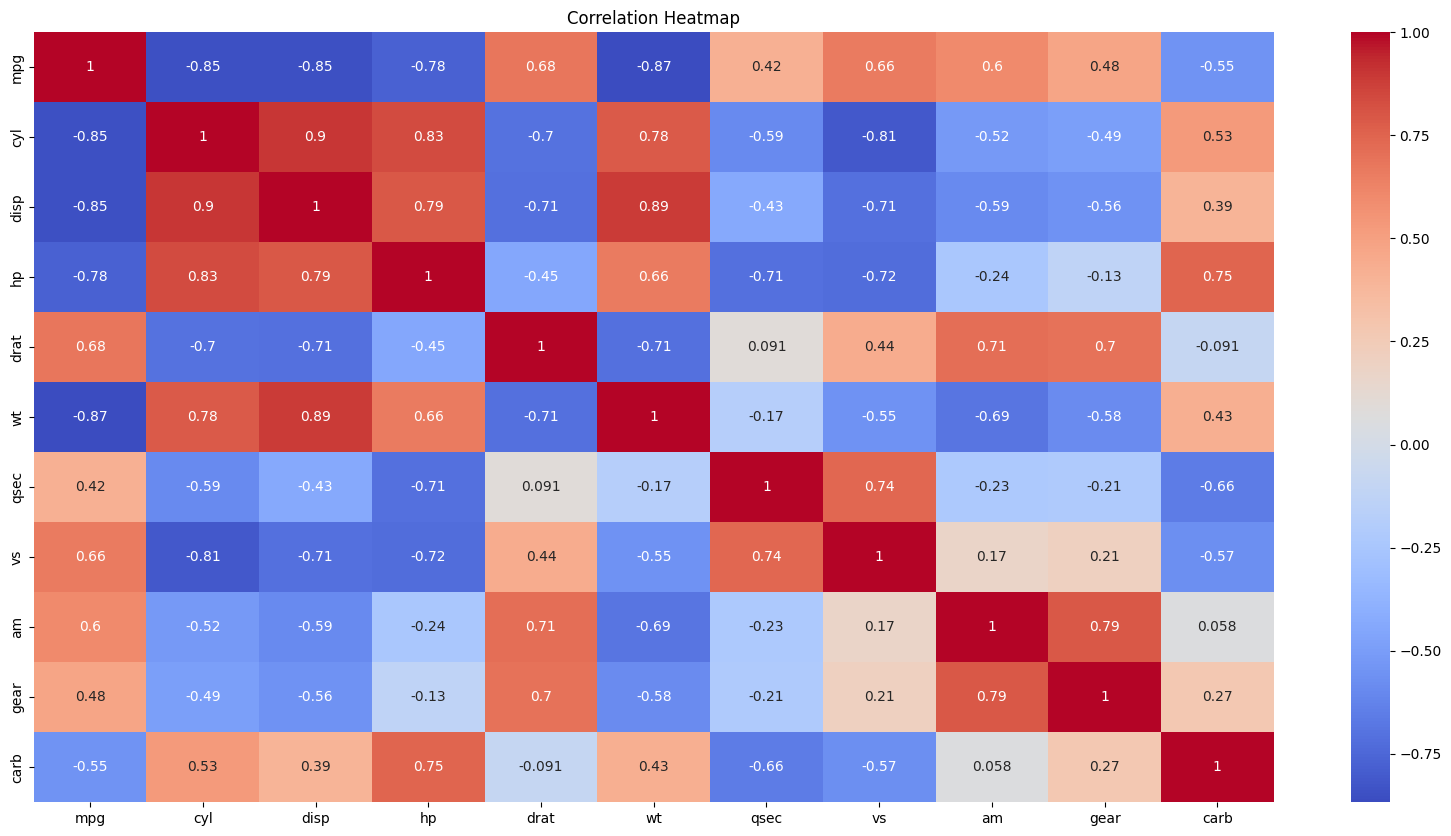

In [16]:
import numpy as np

# Drop non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# Plot the correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [17]:
print(df.head())

               model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2  


In [20]:
# save data cleaned
df.to_csv("/work/mtcars_clean.csv", index=False)

# Clustering

In [27]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset (anggap df adalah dataset yang sudah dibaca sebelumnya)
# df = pd.read_csv("/work/mtcars.csv.csv")  # Jika dataset berada di file .csv

# Pilih kolom yang akan digunakan untuk clustering
features = df[['mpg', 'hp', 'wt']]

# Standarisasi data (penting untuk K-Means)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


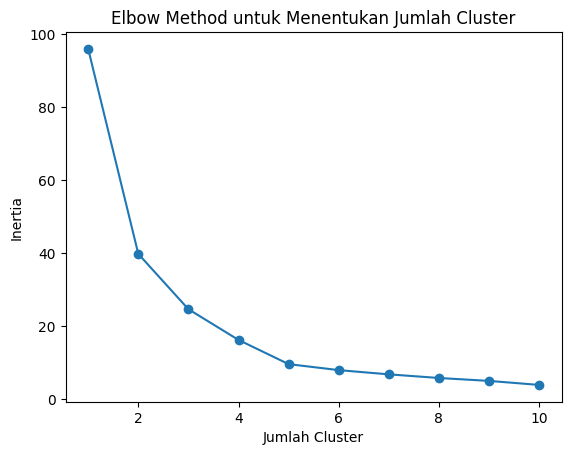

In [28]:
# Menggunakan Elbow Method untuk menentukan jumlah cluster
inertia = []
k_range = range(1, 11)  # Mencoba jumlah cluster dari 1 sampai 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Visualisasikan Elbow Method
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.show()


    mpg   hp     wt  cluster
0  21.0  110  2.620        0
1  21.0  110  2.875        0
2  22.8   93  2.320        0
3  21.4  110  3.215        0
4  18.7  175  3.440        0


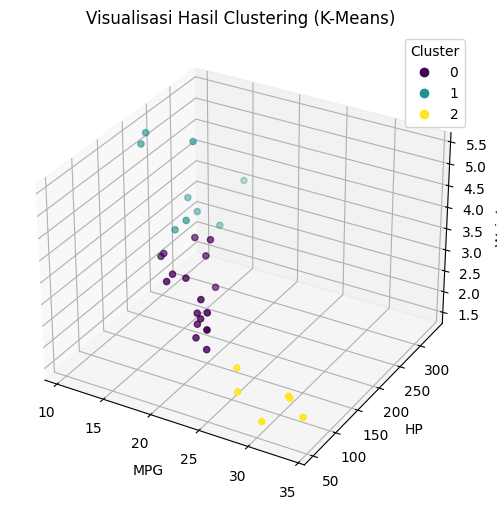

In [29]:
# Misalkan jumlah cluster yang optimal adalah 3 (dari Elbow Method)
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Tampilkan hasil clustering
print(df[['mpg', 'hp', 'wt', 'cluster']].head())

# Visualisasi hasil clustering menggunakan 3D plot (karena kita menggunakan 3 fitur)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['mpg'], df['hp'], df['wt'], c=df['cluster'], cmap='viridis')

# Memberikan label pada sumbu
ax.set_xlabel('MPG')
ax.set_ylabel('HP')
ax.set_zlabel('Weight')

# Menambahkan legenda dan judul
plt.title('Visualisasi Hasil Clustering (K-Means)')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


               mpg          hp        wt
cluster                                 
0        19.823529  126.000000  3.158529
1        13.944444  233.222222  4.224333
2        30.066667   75.500000  1.873000
Silhouette Score: 0.4175512543645643


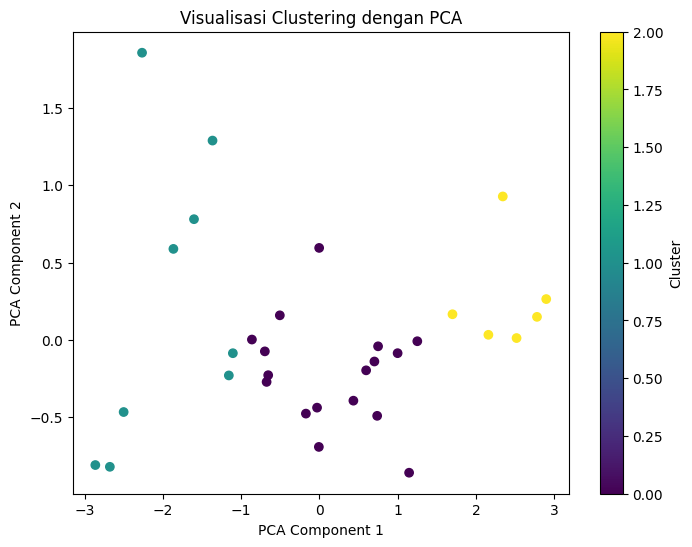

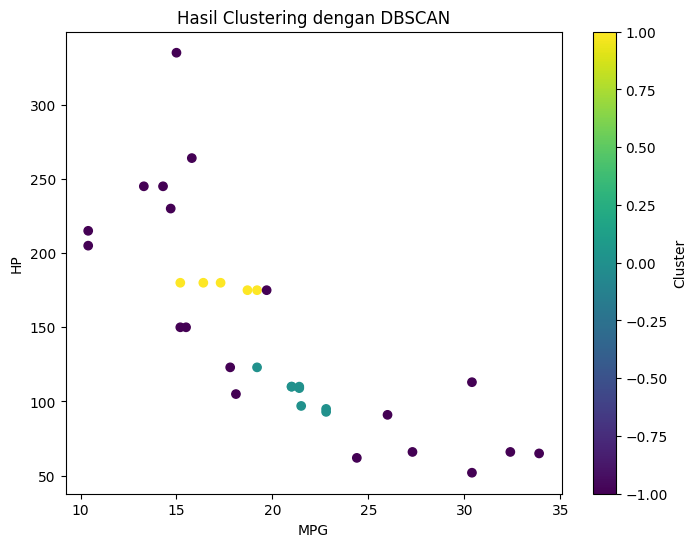

In [30]:
# Menghitung rata-rata statistik untuk setiap cluster
cluster_profiles = df.groupby('cluster')[['mpg', 'hp', 'wt']].mean()
print(cluster_profiles)

from sklearn.metrics import silhouette_score

# Menghitung Silhouette Score
sil_score = silhouette_score(scaled_features, df['cluster'])
print(f'Silhouette Score: {sil_score}')

from sklearn.decomposition import PCA

# Menggunakan PCA untuk mereduksi data ke 2 dimensi
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

# Visualisasi clustering dengan 2D PCA
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=df['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualisasi Clustering dengan PCA')
plt.colorbar(label='Cluster')
plt.show()

from sklearn.cluster import DBSCAN

# Menggunakan DBSCAN untuk clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

# Visualisasi hasil DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(df['mpg'], df['hp'], c=df['dbscan_cluster'], cmap='viridis')
plt.xlabel('MPG')
plt.ylabel('HP')
plt.title('Hasil Clustering dengan DBSCAN')
plt.colorbar(label='Cluster')
plt.show()


In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Hitung total pengeluaran sebagai target
df['mpg'] = df['mpg']  # Asumsikan total_expenses sama dengan total_spending untuk dataset ini

# Definisikan fitur dan target
X = df[['hp', 'wt']]  # Fitur relevan
y = df['mpg']  # Target variabel

# Bagi data menjadi training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat dan latih model Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi pada test set
y_pred = model.predict(X_test)

# Hitung Mean Squared Error dan R-squared
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R squared: {r2}")


Mean Squared Error: 8.474832262021076
R squared: 0.7880448439485954


#  Data Agregation

In [23]:
# agregation
# Membaca dataset
file_path = "/work/mtcars.csv"  # Ganti dengan lokasi file Anda
df = pd.read_csv(file_path)

# 1. Melihat data awal
print("Data awal:")
print(df.head())

# 2. Mengelompokkan data berdasarkan 'cyl' dan menghitung rata-rata, total, dan jumlah untuk 'mpg', 'hp', dan 'wt'
agg_result = df.groupby('cyl').agg(
    avg_mpg=('mpg', 'mean'),
    total_mpg=('mpg', 'sum'),
    count_mpg=('mpg', 'count'),
    avg_hp=('hp', 'mean'),
    total_hp=('hp', 'sum'),
    avg_wt=('wt', 'mean'),
    total_wt=('wt', 'sum')
).reset_index()

# 3. Menampilkan hasil agregasi
print("\nHasil agregasi untuk kolom mpg, hp, dan wt berdasarkan jumlah silinder:")
print(agg_result)

Data awal:
               model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2  

Hasil agregasi untuk kolom mpg, hp, dan wt berdasarkan jumlah silinder:
   cyl    avg_mpg  total_mpg  count_mpg      avg_hp  total_hp    avg_wt  \
0    4  26.663636      293.3         11   82.636364       909  2.285727   
1    6  19.742857      138.2          7  122.285714       856  3.117143   
2    8  15.100000      211.4         14  209.214286      2929  3.999214   

   total_wt  
0    25.143  
1    21.820  
2    55.989  


In [24]:
pivot_table = df.pivot_table(
    values=['mpg', 'hp', 'wt'], 
    index='cyl', 
    aggfunc=['mean', 'sum', 'count']
)
print("\nPivot table hasil agregasi:")
print(pivot_table)



Pivot table hasil agregasi:
           mean                        sum                count        
             hp        mpg        wt    hp    mpg      wt    hp mpg  wt
cyl                                                                    
4     82.636364  26.663636  2.285727   909  293.3  25.143    11  11  11
6    122.285714  19.742857  3.117143   856  138.2  21.820     7   7   7
8    209.214286  15.100000  3.999214  2929  211.4  55.989    14  14  14



Agregasi dengan kolom tambahan (power-to-weight ratio):
   cyl  avg_power_to_weight  max_power_to_weight
0    4            37.925332            74.686054
1    6            39.927938            63.176895
2    8            53.859638            93.837535


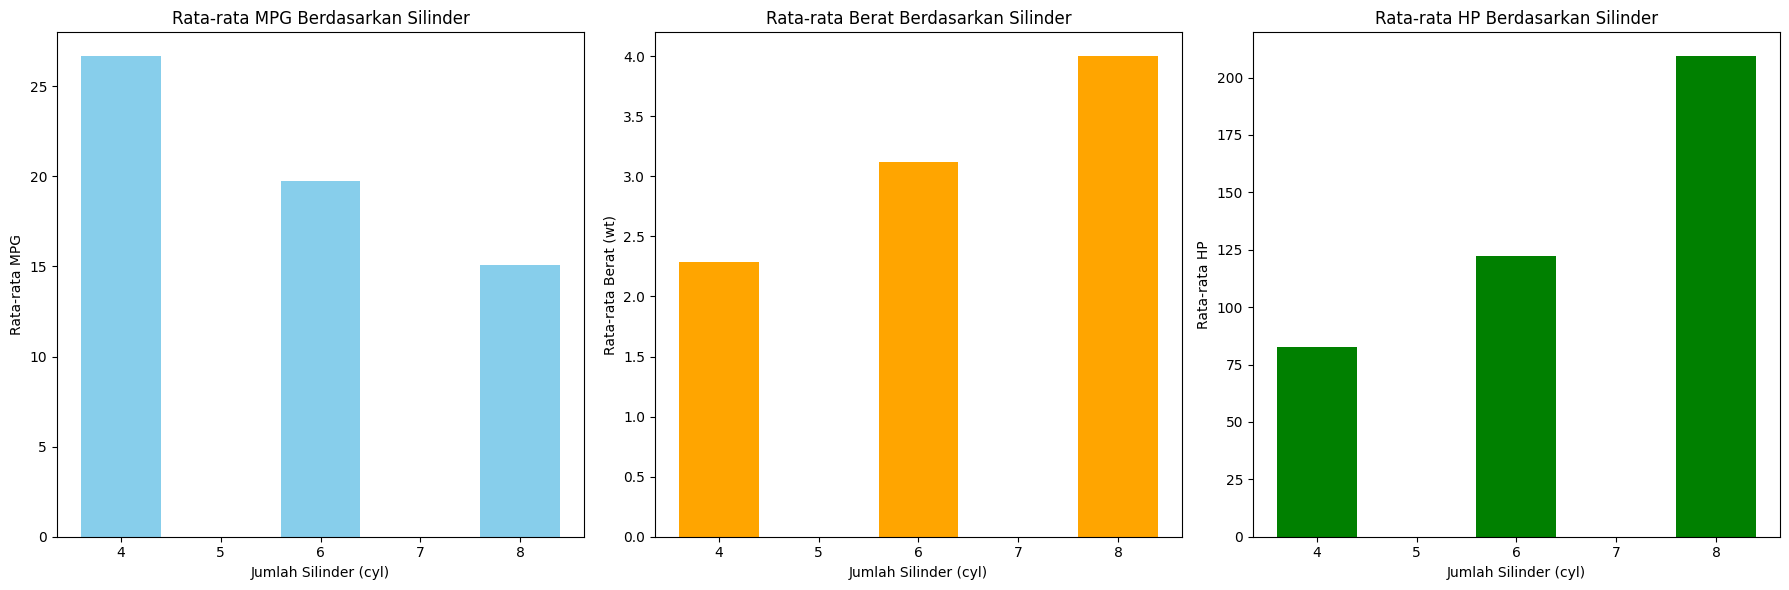

In [25]:
#Menambah Kolom Baru Sebelum Agregasi
# Menambahkan kolom power-to-weight ratio
df['power_to_weight'] = df['hp'] / df['wt']

# Agregasi berdasarkan 'cyl'
agg_result = df.groupby('cyl').agg(
    avg_power_to_weight=('power_to_weight', 'mean'),
    max_power_to_weight=('power_to_weight', 'max')
).reset_index()

print("\nAgregasi dengan kolom tambahan (power-to-weight ratio):")
print(agg_result)

#Visualisasi Hasil Agregasiimport matplotlib.pyplot as plt

# Agregasi rata-rata mpg, wt, dan hp berdasarkan jumlah silinder
agg_result = df.groupby('cyl').agg(
    avg_mpg=('mpg', 'mean'),
    avg_wt=('wt', 'mean'),
    avg_hp=('hp', 'mean')
).reset_index()

# Membuat subplot untuk visualisasi
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Grafik 1: Rata-rata MPG
axes[0].bar(agg_result['cyl'], agg_result['avg_mpg'], color='skyblue')
axes[0].set_xlabel('Jumlah Silinder (cyl)')
axes[0].set_ylabel('Rata-rata MPG')
axes[0].set_title('Rata-rata MPG Berdasarkan Silinder')

# Grafik 2: Rata-rata Berat (Weight)
axes[1].bar(agg_result['cyl'], agg_result['avg_wt'], color='orange')
axes[1].set_xlabel('Jumlah Silinder (cyl)')
axes[1].set_ylabel('Rata-rata Berat (wt)')
axes[1].set_title('Rata-rata Berat Berdasarkan Silinder')

# Grafik 3: Rata-rata Horsepower (HP)
axes[2].bar(agg_result['cyl'], agg_result['avg_hp'], color='green')
axes[2].set_xlabel('Jumlah Silinder (cyl)')
axes[2].set_ylabel('Rata-rata HP')
axes[2].set_title('Rata-rata HP Berdasarkan Silinder')

# Menyesuaikan layout
plt.tight_layout()
plt.show()



# Model Building

hp = horse power > 

wt = 

In [ ]:
!pip install streamlit==1.40.1

               model   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  gear  \
0          Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1     4   
1      Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1     4   
2         Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1     4   
3     Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0     3   
4  Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0     3   

   carb  
0     4  
1     4  
2     1  
3     1  
4     2  
Koefisien: [-0.03431681 -3.75233575]
Intercept: 36.77636883090128
Mean Squared Error: 8.474832262021076
R²: 0.7880448439485954


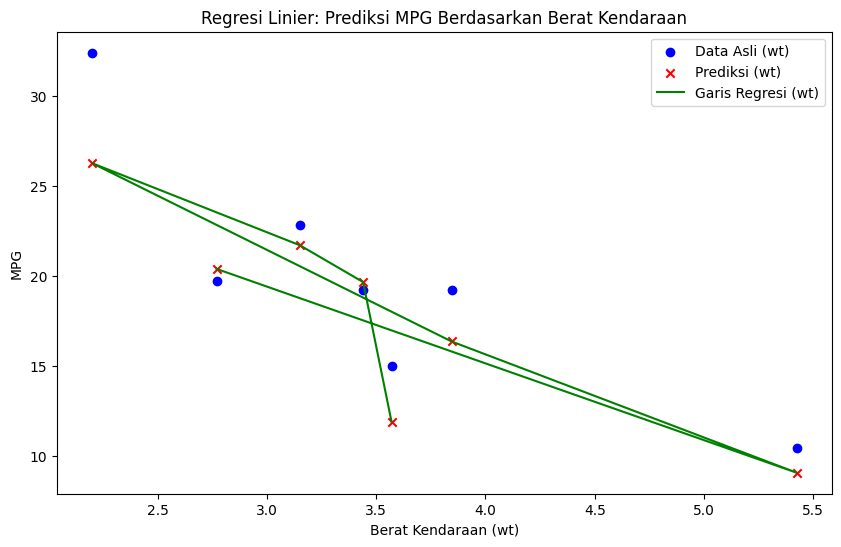

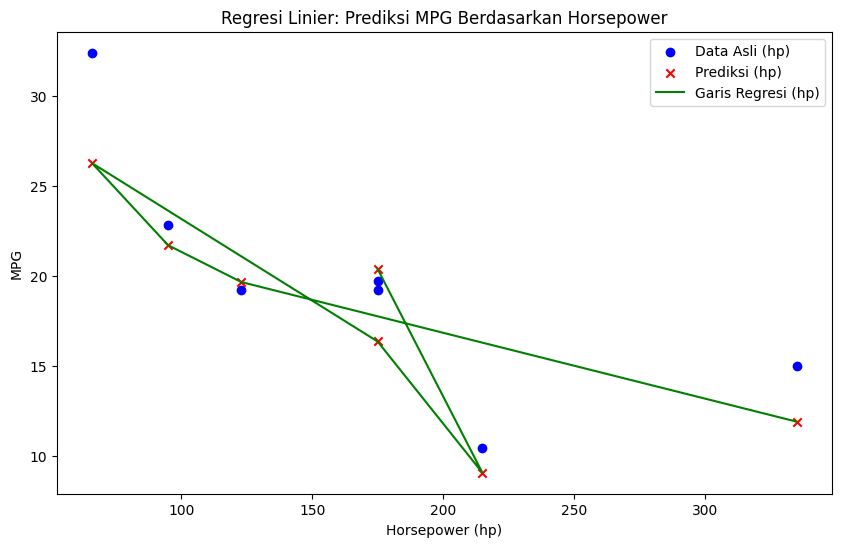

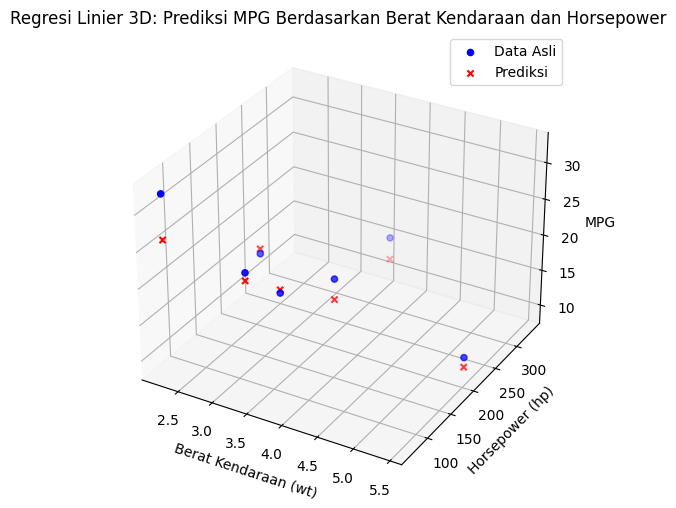

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from mpl_toolkits.mplot3d import Axes3D

# Mengimpor dan mempersiapkan data
# Pastikan dataframe df sudah berisi data yang benar
df = pd.read_csv('/work/mtcars.csv')  # Ganti dengan path ke file Anda jika diperlukan

# Menampilkan 5 baris pertama untuk memeriksa data
print(df.head())

# Memilih fitur dan target
X = df[['hp', 'wt']]  # Fitur (hp dan wt)
y = df['mpg']  # Target (mpg)

# Membagi data menjadi train dan test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Membuat model regresi linier
model = LinearRegression()

# Melatih model menggunakan data pelatihan
model.fit(X_train, y_train)

# Menampilkan koefisien dan intercept model
print(f'Koefisien: {model.coef_}')
print(f'Intercept: {model.intercept_}')

# Prediksi menggunakan data uji
y_pred = model.predict(X_test)

# Menghitung Mean Squared Error (MSE) dan R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R²: {r2}')

# Visualisasi hasil regresi linier (untuk fitur 'wt')
plt.figure(figsize=(10, 6))

# Plot data asli dan prediksi untuk 'wt'
plt.scatter(X_test['wt'], y_test, color='blue', label='Data Asli (wt)')
plt.scatter(X_test['wt'], y_pred, color='red', label='Prediksi (wt)', marker='x')

# Menambahkan garis regresi untuk 'wt'
plt.plot(X_test['wt'], model.predict(X_test), color='green', label='Garis Regresi (wt)')

plt.xlabel('Berat Kendaraan (wt)')
plt.ylabel('MPG')
plt.title('Regresi Linier: Prediksi MPG Berdasarkan Berat Kendaraan')
plt.legend()
plt.show()

# Visualisasi hasil regresi linier (untuk fitur 'hp')
plt.figure(figsize=(10, 6))

# Plot data asli dan prediksi untuk 'hp'
plt.scatter(X_test['hp'], y_test, color='blue', label='Data Asli (hp)')
plt.scatter(X_test['hp'], y_pred, color='red', label='Prediksi (hp)', marker='x')

# Menambahkan garis regresi untuk 'hp'
plt.plot(X_test['hp'], model.predict(X_test), color='green', label='Garis Regresi (hp)')

plt.xlabel('Horsepower (hp)')
plt.ylabel('MPG')
plt.title('Regresi Linier: Prediksi MPG Berdasarkan Horsepower')
plt.legend()
plt.show()

# Visualisasi hasil regresi linier 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Membuat scatter plot untuk data asli
ax.scatter(X_test['wt'], X_test['hp'], y_test, color='blue', label='Data Asli')

# Membuat scatter plot untuk prediksi
ax.scatter(X_test['wt'], X_test['hp'], y_pred, color='red', label='Prediksi', marker='x')

# Menambahkan label dan judul
ax.set_xlabel('Berat Kendaraan (wt)')
ax.set_ylabel('Horsepower (hp)')
ax.set_zlabel('MPG')
ax.set_title('Regresi Linier 3D: Prediksi MPG Berdasarkan Berat Kendaraan dan Horsepower')

# Menampilkan legenda
ax.legend()

# Menampilkan plot
plt.show()


In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the DataFrame from the CSV file since 'df' is not defined
df = pd.read_csv('/work/mtcars.csv')

X = df[['hp', 'wt']].values  # Input: horsepower and weight
y = df['mpg'].values  # Target: miles per gallon

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1))  # Output layer

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

epochs = 20
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
print(f"Test MAE: {mae}")

Epoch 1/20
1/1 [==============================] - 0s 408ms/step - loss: 699.6447 - mae: 26.1431 - val_loss: 626.5018 - val_mae: 24.5557
Epoch 2/20
1/1 [==============================] - 0s 27ms/step - loss: 601.6969 - mae: 24.1043 - val_loss: 520.9926 - val_mae: 22.1468
Epoch 3/20
1/1 [==============================] - 0s 21ms/step - loss: 515.1262 - mae: 22.1027 - val_loss: 430.5298 - val_mae: 19.7580
Epoch 4/20
1/1 [==============================] - 0s 17ms/step - loss: 438.6720 - mae: 20.1179 - val_loss: 355.2300 - val_mae: 17.4060
Epoch 5/20
1/1 [==============================] - 0s 16ms/step - loss: 372.4568 - mae: 18.1612 - val_loss: 298.1432 - val_mae: 15.2439
Epoch 6/20
1/1 [==============================] - 0s 47ms/step - loss: 319.7762 - mae: 16.3679 - val_loss: 253.7081 - val_mae: 13.1437
Epoch 7/20
1/1 [==============================] - 0s 16ms/step - loss: 275.8176 - mae: 14.6228 - val_loss: 220.8718 - val_mae: 11.9157
Epoch 8/20
1/1 [==============================] - 0s 1

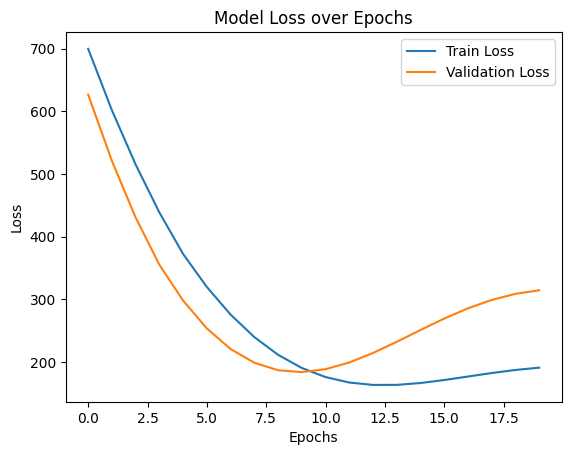

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 65ms/step
Mean Squared Error (MSE): 314.60196729515155
Mean Absolute Error (MAE): 14.102136148725238
R-squared (R²): -6.8681803970265864


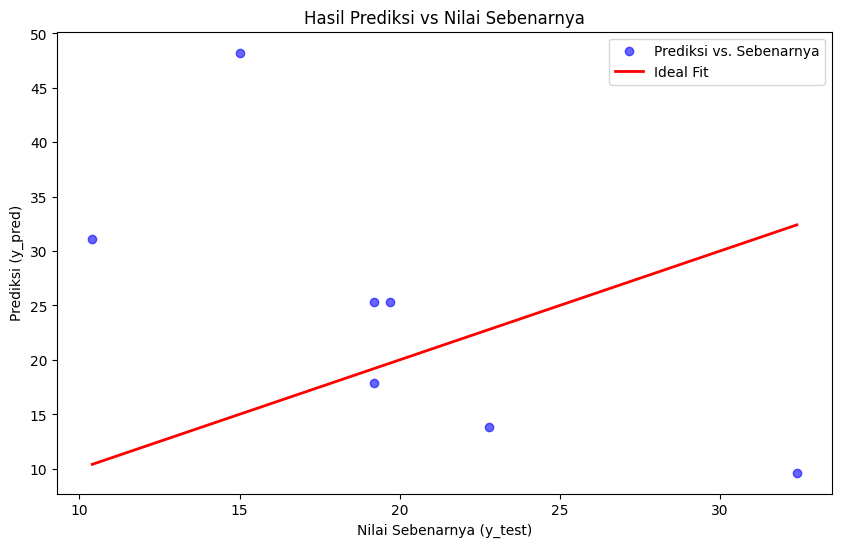

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prediksi pada data uji
y_pred = model.predict(X_test)

# Hitung metrik evaluasi
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Tampilkan hasil evaluasi
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r2}")

# Visualisasi hasil prediksi vs nilai sebenarnya
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Prediksi vs. Sebenarnya')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2, label='Ideal Fit')
plt.xlabel('Nilai Sebenarnya (y_test)')
plt.ylabel('Prediksi (y_pred)')
plt.title('Hasil Prediksi vs Nilai Sebenarnya')
plt.legend()
plt.show()

In [6]:
model.save('model_rekomendasi_pengeluaran.h5')

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=67d475ff-211f-48f8-8a50-a7841fbce5fd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>